<a href="https://colab.research.google.com/github/bruceMacLeod/COS475-575/blob/main/Lab/bikeshare-end-to-end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook explains how we can go about explore and prepare data for model building.The notebook is structured in the following way 

 - Problem Definition
 - Data Gathering and Import
 - Data Wrangling/Cleaning
 - Exploratory Data Analysis
 - Data Modeling
 - Prediction

 References/Source:
    - https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb
    - https://github.com/usm-cos422-522/courseMaterials/blob/main/Labs/titanic-workflow.ipynb
    - https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile
    - https://www.kaggle.com/miteshyadav/comprehensive-eda-with-xgboost-top-10-percentile

## Problem Definition

#### Goal

To forecast bike rental demand in the Capital Bikeshare program in Washington, D.C. by combining historical usage patterns with weather data in order to forecast bike rental demand. 

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

#### **Data Fields**

* dteday - date
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter
* yr - year
* mnth - month
* hr - hour
* holiday - whether the day is considered a holiday
* weekday
* workingday - whether the day is neither a weekend nor holiday
* weathersit -
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* cnt - number of total rentals (Dependent Variable)



##  Data Gathering and Import

In [3]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# libraries for reading url based files
import os
import tarfile
import urllib

# libraries for recoding fields and pipeline construction
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder

# libraries for model building
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error

pd.options.mode.chained_assignment = None
%matplotlib inline

### **Read In The Dataset from the UCI data repository**

The data file is located at https://archive.ics.uci.edu/ml/machine-learning-databases/00275/  We will have to download the zip file and then extract the hourly data

In [4]:

DOWNLOAD_ROOT = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/"
LOCAL_DATA_PATH = os.path.join("datasets", "bikeshare") + "/"
FILE_NAME = "Bike-Sharing-Dataset.zip"

def fetch_bikeshare_data(file_name = FILE_NAME, bikeshare_url=DOWNLOAD_ROOT,  bikeshare_path=LOCAL_DATA_PATH): 
    os.makedirs(bikeshare_path, exist_ok=True)
    xpt_path = os.path.join(bikeshare_path, file_name) 
    url = bikeshare_url + file_name
    urllib.request.urlretrieve(url, xpt_path)

In [5]:
fetch_bikeshare_data()

In [6]:
!unzip -o datasets/bikeshare/Bike-Sharing-Dataset -d ./datasets/bikeshare
!ls datasets/bikeshare

Archive:  datasets/bikeshare/Bike-Sharing-Dataset.zip
  inflating: ./datasets/bikeshare/Readme.txt  
  inflating: ./datasets/bikeshare/day.csv  
  inflating: ./datasets/bikeshare/hour.csv  
Bike-Sharing-Dataset.zip  day.csv  hour.csv  Readme.txt


In [7]:
df = pd.read_csv('./datasets/bikeshare/hour.csv',parse_dates=['dteday'])
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Exploring Data Structure and Features


As a first step lets do three simple steps on the dataset

 - Size of the dataset
 - Get a glimpse of data by printing few rows of it.
 - What type of variables contribute our data

#### **Shape Of The Dataset**

In [8]:
df.shape

(17379, 17)

#### **Sample Of First Few Rows**

In [9]:
df.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


#### **Variables Data Type**

In [10]:
df.dtypes

instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
hr                     int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

 #### Do we have missing values ?
  find out whether we have any missing values in our data. Luckily we dont have any missing value in the dataset.

In [11]:
pd.DataFrame({'Number of Missing Values (Training)': df.isna().sum(),
              '% of Missing Values (Training)': (df.isna().sum()/df.shape[0] * 100).round(2)})

,Number of Missing Values (Training),% of Missing Values (Training)
instant,0,0.0
dteday,0,0.0
season,0,0.0
yr,0,0.0
mnth,0,0.0
hr,0,0.0
holiday,0,0.0
weekday,0,0.0
workingday,0,0.0
weathersit,0,0.0


### Visualize Distribution Of Data
As it is visible from the below figures that "count" variable is skewed towards right. It is desirable to have Normal distribution as most of the machine learning techniques require dependent variable to be Normal. One possible solution is to take log transformation on "count" variable after removing outlier data points. After the transformation the data looks lot better but still not ideally following normal distribution.

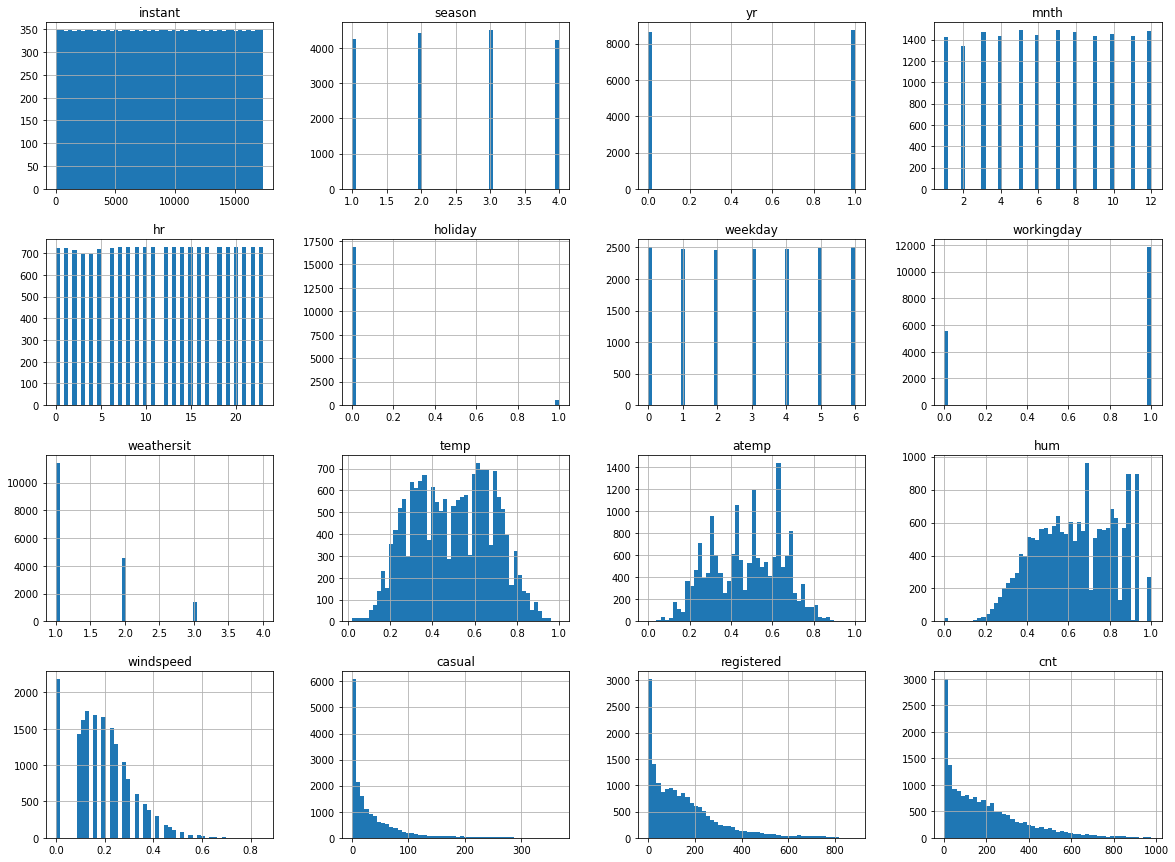

In [12]:
df.hist(bins=50, figsize=(20,15))
plt.show()

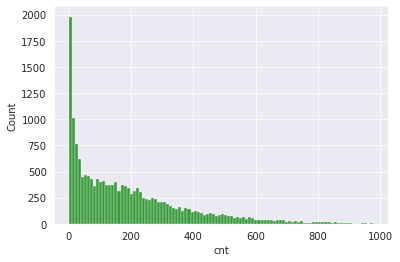

In [13]:
#Histogram for count; this is our dependent variable ... let's look close
sns.set_style('darkgrid')
sns.histplot(df['cnt'], bins = 100, color = 'green')
plt.show()

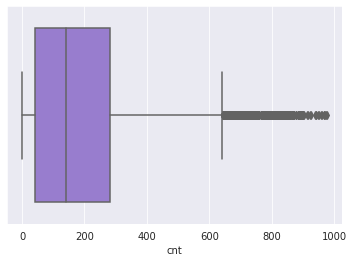

In [14]:
#Boxplot for count
# The whiskers extend from the box by 1.5x the inter-quartile range (IQR)
import matplotlib.pyplot as plt
sns.boxplot(x = 'cnt', data = df, color = 'mediumpurple')
plt.show()

These three charts above can tell us a lot about our target variable.

Our target variable, count is not normally distributed.
There are multiple outliers in the variable. We could get rid of outside the 1.5x IQR of 3 standard deviations. We choose the later

### Create training and test dataframes

Strategy : use the first 24 days of the month as training data and the remaining days are test data


In [15]:
cutoff_day = 24
train_df = df[df.dteday.dt.day <=cutoff_day]
test_df = df[df.dteday.dt.day>cutoff_day]
print("training rows", train_df.shape[0])
print("test rows", test_df.shape[0])
print("training ratio", train_df.shape[0]/df.shape[0])

training rows 13749
test rows 3630
training ratio 0.7911272225099257


#### **Lets Remove Outliers In The Count Column**

In [16]:
outliers = train_df[np.abs(train_df["cnt"]-train_df["cnt"].mean())>(3*train_df["cnt"].std())]
print((len(outliers)/len(train_df))*100)                                                  

1.4110117099425412


In [17]:
print(outliers.shape)
print(train_df.shape)

(194, 17)
(13749, 17)


In [18]:
#Data without the outliers in count
train_df = train_df[~train_df.isin(outliers)].dropna()
train_df.shape

(13555, 17)

#### Visualizing Distribution Of Count Data after removing outliers
As it is visible from the below figures that "count" variable is skewed towards right. It is desirable to have Normal distribution as most of the machine learning techniques require dependent variable to be Normal. One possible solution is to take log transformation on "count" variable after removing outlier data points. After the transformation the data looks lot better but still not ideally following normal distribution.

[Text(0.5, 0, 'log number of rentals'), Text(0.5, 1.0, 'log cnt histogram')]

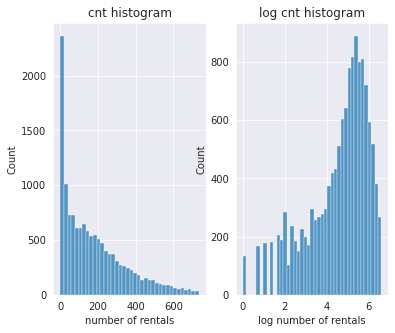

In [19]:
fig,axes = plt.subplots(ncols=2,nrows=1)
fig.set_size_inches(6, 5)
sns.histplot(train_df["cnt"],ax=axes[0])
sns.histplot(np.log(train_df["cnt"]),ax=axes[1])
axes[0].set(xlabel='number of rentals', ylabel='Count',title="cnt histogram")
axes[1].set(xlabel='log number of rentals',title="log cnt histogram")

#### Correlation Analysis
One common way to understand how a dependent variable is influenced by features (numerical) is to build a correlation matrix. 


In [20]:
# select a subset of variables we are interested in 

corr = train_df[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed','cnt']].corr()
corr['cnt'].sort_values(ascending=False)

cnt           1.000000
hr            0.400733
temp          0.394510
atemp         0.389529
yr            0.228082
season        0.166198
mnth          0.145295
windspeed     0.092014
weekday       0.029607
workingday   -0.010156
holiday      -0.019708
weathersit   -0.133317
hum          -0.316397
Name: cnt, dtype: float64

 - temp and humidity features have positive and negative correlation
   with count respectively.Although the correlation between them are not
   very prominent still the count variable has little dependency on
   "temp" and "humidity".
 - windspeed is not really useful numerical feature and it is visible from it correlation value with "count"
 - "atemp" is variable is not taken into since "atemp" and "temp" has got strong correlation with each other. During model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data.
 - "Casual" and "Registered" are also not taken into account since they are leakage variables in nature and need to dropped during model building.


#### Visualizing Count Vs (Month,Season,Hour,Weekday,Usertype)

 - It is quiet obvious that people tend to rent bike during summer
   season since it is really conducive to ride bike at that
   season.Therefore June, July and August has got relatively higher
   demand for bicycle.
 - On weekdays more people tend to rent bicycle around 7AM-8AM and 5PM-6PM. As we mentioned earlier this can be attributed to regular school and office commuters.
 - Above pattern is not observed on "Saturday" and "Sunday".More people tend to rent bicycle between 10AM and 4PM.
 - The peak user count around 7AM-8AM and 5PM-6PM is purely contributed by registered user.

[Text(0, 0.5, 'Users Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

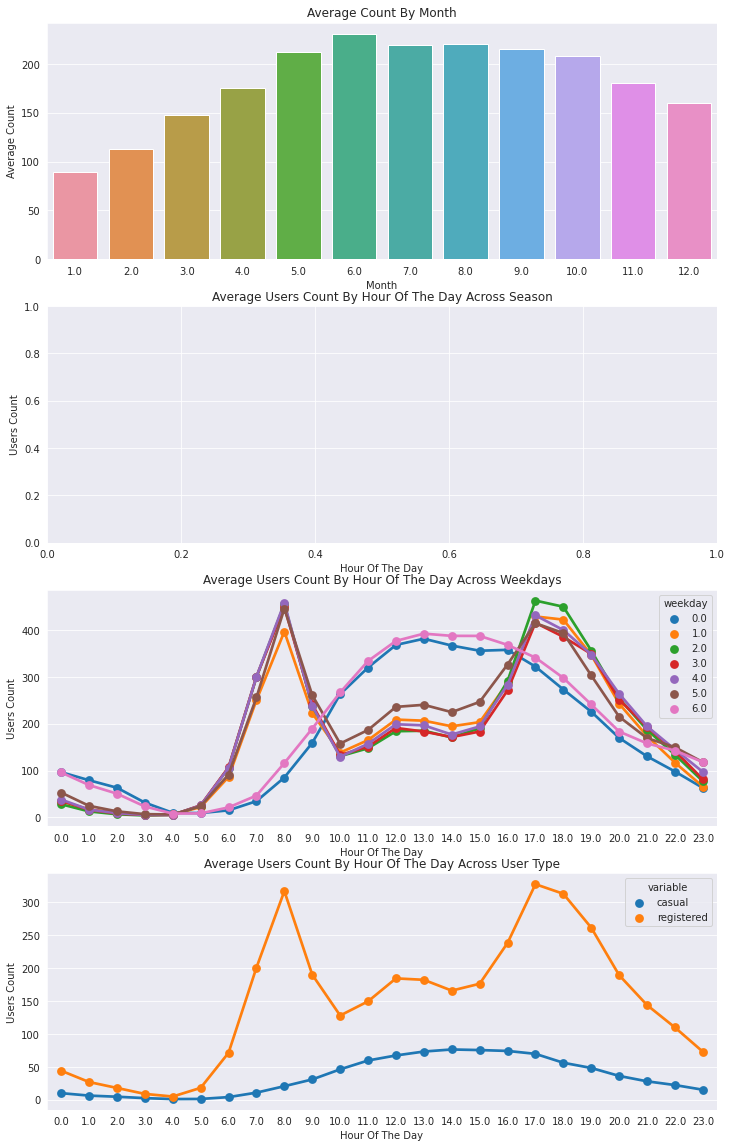

In [21]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(train_df.groupby("mnth")["cnt"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="cnt",ascending=False)
sns.barplot(data=monthSorted,x="mnth",y="cnt",ax=ax1)
ax1.set(xlabel='Month', ylabel='Average Count',title="Average Count By Month")

ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(train_df.groupby(["hr","weekday"],sort=True)["cnt"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hr"], y=hourAggregated["cnt"],hue=hourAggregated["weekday"], data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(train_df[["hr","casual","registered"]], id_vars=['hr'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hr","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hr"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

**So we have visualized the data to a greater extent.So lets go and  build some models and see how close we can predict the results.**

###  Drop, recode, and normalize columns

In [22]:
#categoricalFeatures = ["season","holiday","workingday","weathersit","weekday","mnth","yr","hr"]
#numericalFeatures = ["hum","windspeed","atemp"]
#dropFeatures = ['instant','casual',"dteday","registered","temp"]

categoricalFeatures = ["weathersit","holiday","season","workingday","weekday","mnth","yr","hr"]
numericalFeatures = ["hum","windspeed","atemp"]
dropFeatures = ['instant','casual',"dteday","registered","temp"]

In [23]:
df_sub = train_df.drop(dropFeatures, axis=1)
df_num = df_sub[numericalFeatures]
df_cat = df_sub[categoricalFeatures]

In [24]:
df_sub.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.2879,0.81,0.0,16.0
1,1.0,0.0,1.0,1.0,0.0,6.0,0.0,1.0,0.2727,0.80,0.0,40.0
2,1.0,0.0,1.0,2.0,0.0,6.0,0.0,1.0,0.2727,0.80,0.0,32.0
3,1.0,0.0,1.0,3.0,0.0,6.0,0.0,1.0,0.2879,0.75,0.0,13.0
4,1.0,0.0,1.0,4.0,0.0,6.0,0.0,1.0,0.2879,0.75,0.0,1.0


In [25]:
df_num.head()

,hum,windspeed,atemp
0,0.81,0.0,0.2879
1,0.80,0.0,0.2727
2,0.80,0.0,0.2727
3,0.75,0.0,0.2879
4,0.75,0.0,0.2879


In [26]:
df_cat.head()

,weathersit,holiday,season,workingday,weekday,mnth,yr,hr
0,1.0,0.0,1.0,0.0,6.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,6.0,1.0,0.0,1.0
2,1.0,0.0,1.0,0.0,6.0,1.0,0.0,2.0
3,1.0,0.0,1.0,0.0,6.0,1.0,0.0,3.0
4,1.0,0.0,1.0,0.0,6.0,1.0,0.0,4.0


In [27]:
bike_y = train_df['cnt']
bike_y.shape

(13555,)

In [28]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
        ])

In [29]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numericalFeatures),
        ("cat", OneHotEncoder(), categoricalFeatures),
        ])
bike_X = full_pipeline.fit_transform(train_df)

In [30]:
# the bike creates a sparse matrix, lets look at the first rows
bike_X.todense()[:2,:]

matrix([[ 0.93169462, -1.54156385, -1.0807267 ,  1.        ,  0.        ,
          0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
          0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
          0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.87992808, -1.54156385, -1.16988742,  1.        ,  0.        ,
          0.        ,  0.        ,  1

In [31]:
bike_X.shape

(13555, 60)

## Data Modeling

### **Linear Regression Model** ##

In [32]:
# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
lModel.fit(X = bike_X,y = bike_y)

# Make predictions
count_preds = lModel.predict(X=bike_X)
lin_mse = mean_squared_error(bike_y, count_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse
print ("RMSLE Value For Linear Regression: ",lin_rmse)

RMSLE Value For Linear Regression:  94.823383886753


### Better Evaluation Using Cross-Validation

In [33]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lModel, bike_X, bike_y,
                         scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
rmse_scores

array([ 91.41842228,  77.85595549,  86.79862928,  81.56690757,
        76.33427952,  81.49098134, 116.5189924 , 119.87914645,
       123.11456549, 110.48504299])

In [34]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [35]:

display_scores(rmse_scores)

Scores: [ 91.41842228  77.85595549  86.79862928  81.56690757  76.33427952
  81.49098134 116.5189924  119.87914645 123.11456549 110.48504299]
Mean: 96.54629228032385
Standard deviation: 17.81489049795873


## Prediction